# $t \bar{t}$

**Goal:** Eval pairAGraph model on $t\bar{t}$.


In [1]:
import pandas as pd
import numpy as np
import itertools
from itertools import combinations
from tqdm import tqdm
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import gridspec

import json
import time
import h5py
import uproot
import torch

from trainNet import pairAGraph
from preprocess import truthInfo, parallelTruthMatchJets, parallelGetCorrectPair
from preprocess import processDf, scale, applyCuts, pairAndProcess

import os
os.sys.path.append('../code')
from analysis import fileDir, normalizeWeight, read_tsv
from AnalysisUtils import nanoToDf
from eventDisplays import truthDisplay

from plotting import SR_x, SR_y1, SR_y2
from plotting import CR_x, CR_y1, CR_y2
from plotting import SB_x, SB_y1, SB_y2

os.sys.path.append('../eda_tools')
from plot_helper import massplane

%load_ext autoreload
%autoreload 2

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


Running w/ conda env: don't import root packages.


In [2]:
# import sys

# # These are the usual ipython objects, including this one you are creating
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# # Get a sorted list of the objects and their sizes
# sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

**ami DSIDs**

- 410470: $t\bar{t}$ semileptonic
- 410471: $t\bar{t}$ all hadronic


In [3]:
%%bash
ls ../../public/hh4b/ttbar/user.bstanisl.HH4B.410470.ttbar.MC16a-2015-2016.AB21.2.91-MAR20-0.min_MiniNTuple.root/

user.bstanisl.20763291._000001.MiniNTuple.root
user.bstanisl.20763291._000002.MiniNTuple.root
user.bstanisl.20763291._000004.MiniNTuple.root
user.bstanisl.20763291._000005.MiniNTuple.root
user.bstanisl.20763291._000007.MiniNTuple.root
user.bstanisl.20763291._000008.MiniNTuple.root
user.bstanisl.20763291._000009.MiniNTuple.root
user.bstanisl.20763291._000010.MiniNTuple.root
user.bstanisl.20763291._000011.MiniNTuple.root
user.bstanisl.20763291._000015.MiniNTuple.root
user.bstanisl.20763291._000016.MiniNTuple.root
user.bstanisl.20763291._000017.MiniNTuple.root
user.bstanisl.20763291._000019.MiniNTuple.root
user.bstanisl.20763291._000020.MiniNTuple.root
user.bstanisl.20763291._000021.MiniNTuple.root
user.bstanisl.20763291._000022.MiniNTuple.root
user.bstanisl.20763291._000023.MiniNTuple.root
user.bstanisl.20763291._000024.MiniNTuple.root
user.bstanisl.20763291._000025.MiniNTuple.root


In [4]:
%%bash
ls ../../public/hh4b/ttbar/user.bstanisl.HH4B.410471.ttbar.MC16a-2015-2016.AB21.2.91-MAR20-0.min_MiniNTuple.root/

user.bstanisl.20763297._000001.MiniNTuple.root
user.bstanisl.20763297._000002.MiniNTuple.root
user.bstanisl.20763297._000003.MiniNTuple.root
user.bstanisl.20763297._000004.MiniNTuple.root
user.bstanisl.20763297._000005.MiniNTuple.root
user.bstanisl.20763297._000006.MiniNTuple.root
user.bstanisl.20763297._000007.MiniNTuple.root
user.bstanisl.20763297._000008.MiniNTuple.root
user.bstanisl.20763297._000009.MiniNTuple.root
user.bstanisl.20763297._000010.MiniNTuple.root


Is it suspicious that we're missing file number 3,6,12,13,14 from the semileptonic samples?

I asked in NRY - we'll see what they say! 

But I guess rn we're just trying to check the MNT columns anyways.

**Step 1:** Sanity check the MNT columns

In [5]:
testFile = '../../public/hh4b/ttbar/user.bstanisl.HH4B.410470.ttbar.MC16a-2015-2016.AB21.2.91-MAR20-0.min_MiniNTuple.root/user.bstanisl.20763291._000001.MiniNTuple.root'

In [6]:
f = uproot.open(testFile)
t = f[b"XhhMiniNtuple;1"]

In [7]:
for k in t.keys():
    print(k)

b'runNumber'
b'eventNumber'
b'lumiBlock'
b'coreFlags'
b'bcid'
b'mcEventNumber'
b'mcChannelNumber'
b'mcEventWeight'
b'NPV'
b'actualInteractionsPerCrossing'
b'averageInteractionsPerCrossing'
b'weight_pileup'
b'correctedAverageMu'
b'correctedAndScaledAverageMu'
b'correctedActualMu'
b'correctedAndScaledActualMu'
b'rand_run_nr'
b'rand_lumiblock_nr'
b'passedTriggerHashes'
b'nresolvedJets'
b'resolvedJets_E'
b'resolvedJets_pt'
b'resolvedJets_phi'
b'resolvedJets_eta'
b'resolvedJets_is_DL1r_FixedCutBEff_77'
b'resolvedJets_SF_DL1r_FixedCutBEff_77'
b'resolvedJets_Quantile_DL1r_Continuous'
b'resolvedJets_SF_DL1r_Continuous'
b'resolvedJets_InefficiencySF_DL1r_Continuous'
b'nboostedJets'
b'boostedJets_m'
b'boostedJets_pt'
b'boostedJets_phi'
b'boostedJets_eta'
b'nboostedTrkJets'
b'boostedTrkJets_E'
b'boostedTrkJets_pt'
b'boostedTrkJets_phi'
b'boostedTrkJets_eta'
b'boostedTrkJets_is_DL1r_FixedCutBEff_77'
b'boostedTrkJets_SF_DL1r_FixedCutBEff_77'
b'boostedTrkJets_is_DL1r_FixedCutBEff_70'
b'boostedTrkJet

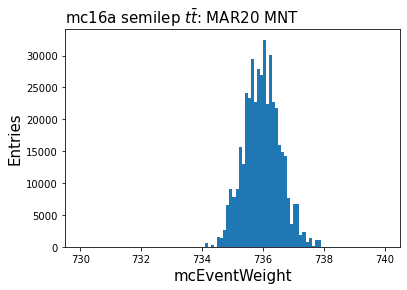

In [8]:
plt.hist(t.array('mcEventWeight'),100,(730,740))
plt.xlabel('mcEventWeight',fontsize=15)
plt.ylabel('Entries',fontsize=15)
plt.title(r'mc16a semilep $t\bar{t}$: MAR20 MNT',loc='left',fontsize=15)
plt.show()

I was a little curious why `mcEventWeight` was so large. Sean said it's because the initial event weights that we divide by is hella large.

In [9]:
f['MetaData_EventCount_XhhMiniNtuple'].allvalues[3]

2015053804.012207

... as it is!

## And now for a few sanity check plots!


### Massplanes

In [10]:
import dask.dataframe as dd
# from dask.distributed import Client, progress
# client = Client(n_workers=2, threads_per_worker=2, memory_limit='10GB')
# client

In [11]:
dirTag = '_ttbar_mc16a_PFlow-MAR2020-5jets'
trSample = 'SM_2b'

In [12]:
semilep_2b = dd.read_hdf(f'../data/semilep{dirTag}/df_{trSample}_*_2b.h5', 'df', mode='r')

Calculate the $|\Delta \eta_{hh}|$ variable

In [13]:
# for ddf in [semilep_2b,semilep_3b,allhad_2b,allhad_3b]:
#     ddf['abs_deta_hh'] = (ddf['eta_h1'] - ddf['eta_h2']).abs()

In [14]:
ddf = semilep_2b

In [15]:
ddf.head()

run_number  event_number     mc_sf  ntag  njets  kinematic_region  \
entry                                                                      
1          307306      48046460  0.106691     2      4                -1   
3          302925      48046260  0.093585     2      5                -1   
7          308084      48047931  0.098016     2      4                 2   
9          304337      48047720  0.082569     2      5                -1   
11         302393      48047087  0.100737     2      5                -1   

             m_hh       pt_hh      X_wt    m_hh_cor  ...      Phi1  ml_j0_Db  \
entry                                                ...                       
1      210.385120  160.986111  1.424396  555.407617  ...  1.126509      -2.0   
3      278.006758   46.696542  1.527297  350.830178  ... -0.072588       2.0   
7      328.172470  151.698001  1.641103  447.622263  ... -2.103226       1.0   
9      445.757550   38.408248  1.491415  796.971633  ...  1.986670       0.0   
11     516.253719  190.386678  0.373065  640.151437  ... -2.802623      -2.0   

       ml_j1_Db  ml_j2_Db  ml_j3_Db  ml_j4_Db          HT    MDR  MDpT  \
entry                                                                    
1           1.0       1.0      -2.0       0.0  241.685535  False  True   
3           2.0      -1.0      -2.0      -2.0  194.145248  False  True   
7           2.0      -2.0      -2.0       0.0  344.159916   True  True   
9           1.0      -2.0      -2.0      -2.0  306.206814  False  True   
11         -2.0       2.0       2.0      -2.0  507.119484   True  True   

       max_prob  
entry            
1      0.430831  
3      0.336310  
7      0.982970  
9      0.671956  
11     0.717798  

[5 rows x 41 columns]

In [16]:
m_h1 = ddf['m_h1'].compute()

In [17]:
m_h2 = ddf['m_h2'].compute()

In [18]:
mc_sf = ddf['mc_sf'].compute()

In [19]:
ddf['abs_deta_hh'] = (ddf['eta_h1'] - ddf['eta_h2']).abs()
abs_deta_hh = ddf['abs_deta_hh'].compute()

In [20]:
X_wt = ddf['X_wt'].compute()

In [21]:
dfi = pd.DataFrame(np.vstack([m_h1.values,m_h2.values,mc_sf.values]).T,
                   columns=['m_h1','m_h2','mc_sf'])

SR center: (120.0,110.0) GeV


<module 'matplotlib.pyplot' from '/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

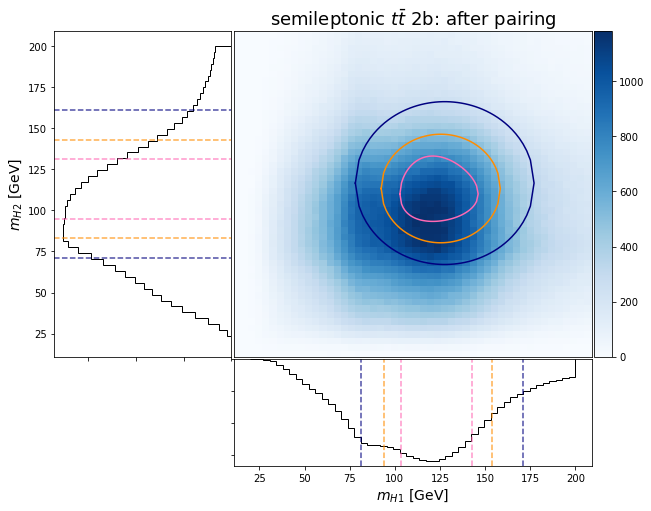

In [22]:
massplane(dfi,cmap='Blues',title=r'semileptonic $t\bar{t}$ 2b: after pairing',
          bins=[50,50],weights=mc_sf,save=True,
          filename=f'figures/semilep_ttbar_mc16a_PFlow-MAR2020-5jets/SM_2b/massplane_2b_afterPairing.pdf')

In [23]:
mi = (abs_deta_hh < 1.5).values

In [24]:
mc_sf[mi]

entry
1          0.106691
7          0.098016
11         0.100737
17         0.096110
19         0.094044
             ...   
2469962    0.089494
2469966    0.090822
2469968   -0.109075
2469972    0.079987
2469976    0.096331
Name: mc_sf, Length: 6740420, dtype: float64

SR center: (120.0,110.0) GeV


<module 'matplotlib.pyplot' from '/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

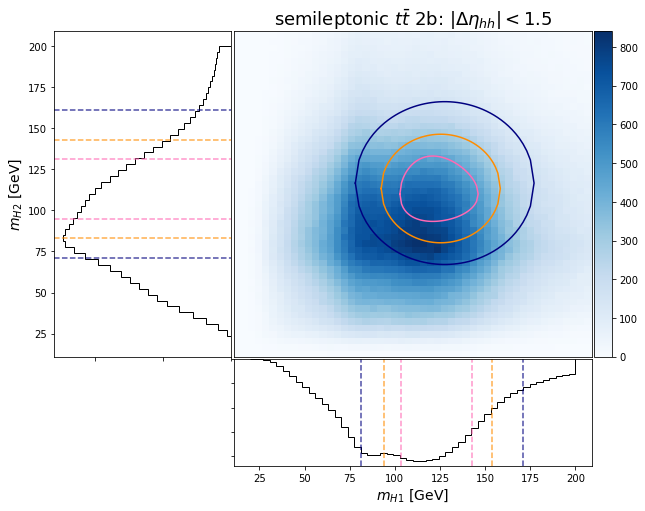

In [25]:
mi = (abs_deta_hh < 1.5).values
massplane(dfi[mi],cmap='Blues',title=r'semileptonic $t\bar{t}$ 2b: $|\Delta \eta_{hh}| < 1.5$',
          bins=[50,50],weights=mc_sf[mi],save=True,
          filename=f'figures/semilep_ttbar_mc16a_PFlow-MAR2020-5jets/SM_2b/massplane_2b_deta_hh_cut.pdf')

SR center: (120.0,110.0) GeV


<module 'matplotlib.pyplot' from '/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

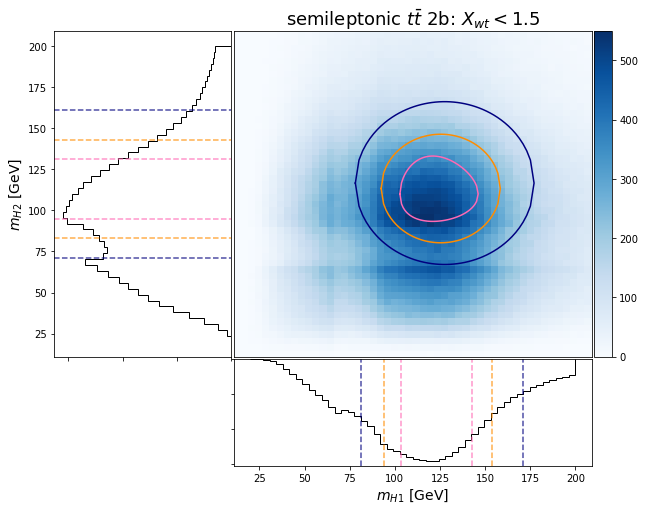

In [26]:
mi = ((abs_deta_hh < 1.5) & (X_wt > 1.5)).values
massplane(dfi[mi],cmap='Blues',title=r'semileptonic $t\bar{t}$ 2b: $X_{wt} < 1.5$',
          bins=[50,50],weights=mc_sf[mi],save=True,
          filename=f'figures/semilep_ttbar_mc16a_PFlow-MAR2020-5jets/SM_2b/massplane_2b_Xwt_cut.pdf')

**Next: Fully hadronronic**

In [27]:
allhad_2b = dd.read_hdf(f'../data/allhad{dirTag}/df_{trSample}_*_2b.h5','df',mode='r')

In [28]:
ddf = allhad_2b

In [29]:
ddf.tail()

run_number  event_number     mc_sf  ntag  njets  kinematic_region  \
entry                                                                        
1640132      302300     126968980  0.286387     2      5                 2   
1640134      276329     126969173  0.266769     2      5                -1   
1640136      307656     126968903  0.260981     2      4                -1   
1640138      310872     126969917  0.159523     2      5                 1   
1640140      307732     126969693  0.240011     2      4                -1   

               m_hh       pt_hh      X_wt    m_hh_cor  ...      Phi1  \
entry                                                  ...             
1640132  661.679108  159.344028  5.511404  795.626470  ...  0.823372   
1640134  258.263138  493.547725  0.110131  273.680175  ...  2.951984   
1640136  585.203170   78.832856  4.606492  480.974442  ...  1.197380   
1640138  599.791503   74.451752  3.034785  713.582373  ...  0.435010   
1640140  518.124507   27.478653  5.471544  859.807923  ...  1.117803   

         ml_j0_Db  ml_j1_Db  ml_j2_Db  ml_j3_Db  ml_j4_Db          HT    MDR  \
entry                                                                          
1640132      -2.0      -2.0       2.0      -2.0       1.0  394.477360   True   
1640134       1.0      -2.0      -2.0      -2.0       1.0  532.542610  False   
1640136      -2.0       2.0       1.0      -2.0       0.0  409.878113  False   
1640138       2.0      -2.0       2.0      -2.0      -2.0  286.188198  False   
1640140       2.0       2.0      -2.0      -2.0       0.0  426.880657   True   

          MDpT  max_prob  
entry                     
1640132   True  0.956670  
1640134   True  0.323681  
1640136   True  0.995674  
1640138  False  0.733181  
1640140   True  0.999959  

[5 rows x 41 columns]

In [30]:
m_h1 = ddf['m_h1'].compute()
m_h2 = ddf['m_h2'].compute()
mc_sf = ddf['mc_sf'].compute()

dfi = pd.DataFrame(np.vstack([m_h1.values,m_h2.values]).T,
                   columns=['m_h1','m_h2'])

In [31]:
ddf['abs_deta_hh'] = (ddf['eta_h1'] - ddf['eta_h2']).abs()
abs_deta_hh = ddf['abs_deta_hh'].compute()

In [32]:
X_wt = ddf['X_wt'].compute()

SR center: (120.0,110.0) GeV


<module 'matplotlib.pyplot' from '/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

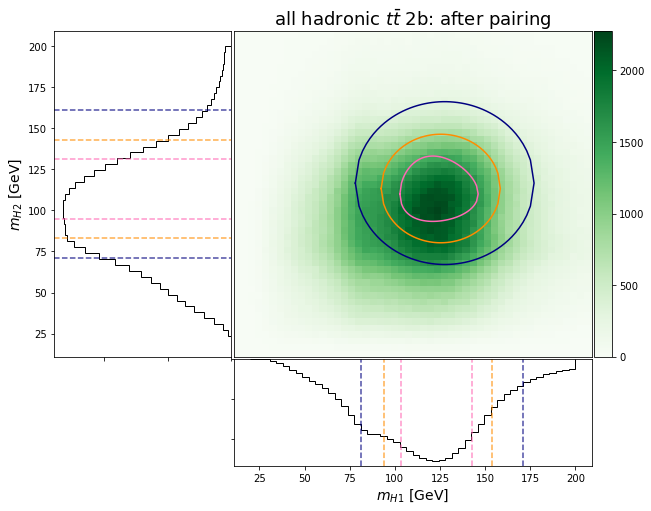

In [33]:
massplane(dfi,cmap='Greens',title=r'all hadronic $t\bar{t}$ 2b: after pairing',
          bins=[50,50],weights=mc_sf,save=True,
          filename=f'figures/allhad_ttbar_mc16a_PFlow-MAR2020-5jets/SM_2b/massplane_2b_afterPairing.pdf')

SR center: (120.0,110.0) GeV


<module 'matplotlib.pyplot' from '/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

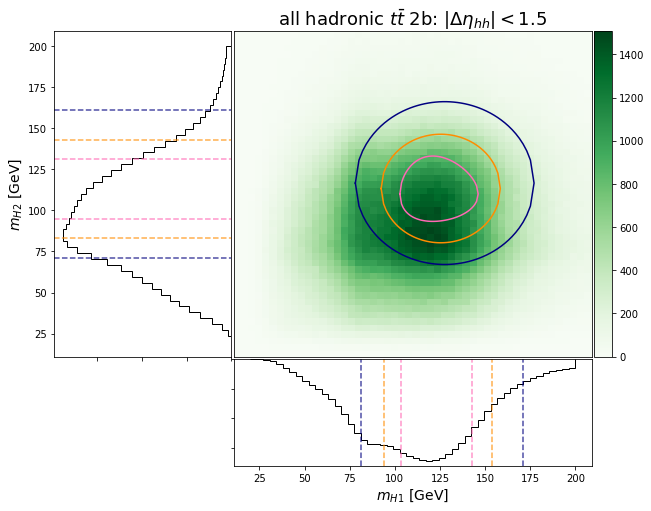

In [34]:
mi = (abs_deta_hh < 1.5).values
massplane(dfi[mi],cmap='Greens',title=r'all hadronic $t\bar{t}$ 2b: $|\Delta \eta_{hh}| < 1.5$',
          bins=[50,50],weights=mc_sf[mi],save=True,
          filename=f'figures/allhad_ttbar_mc16a_PFlow-MAR2020-5jets/SM_2b/massplane_2b_deta_hh_cut.pdf')

SR center: (120.0,110.0) GeV


<module 'matplotlib.pyplot' from '/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

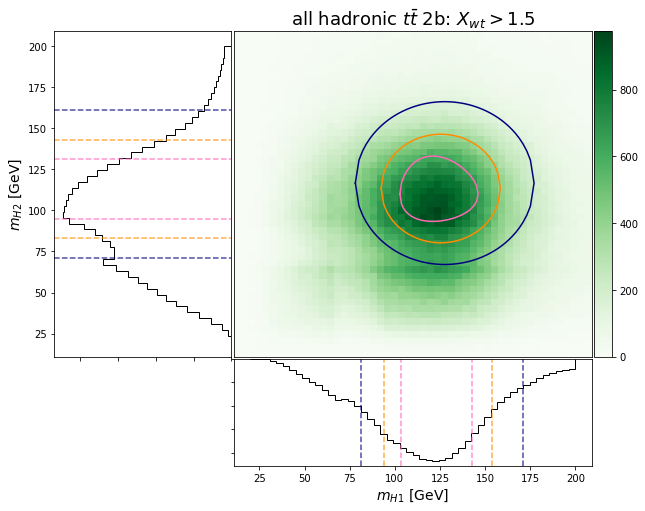

In [35]:
mi = ((abs_deta_hh < 1.5) & (X_wt > 1.5)).values

massplane(dfi[mi],cmap='Greens',title=r'all hadronic $t\bar{t}$ 2b: $X_{wt} > 1.5$',
          bins=[50,50],weights=mc_sf[mi],save=True,
          filename=f'figures/allhad_ttbar_mc16a_PFlow-MAR2020-5jets/SM_2b/massplane_2b_Xwt_cut.pdf')

**And now for the 3b and 4b events**

In [36]:
semilep_3b = dd.read_hdf(f'../data/semilep{dirTag}/df_{trSample}_*_3b.h5','df',mode='r')
allhad_3b = dd.read_hdf(f'../data/allhad{dirTag}/df_{trSample}_*_3b.h5',  'df',mode='r')

In [37]:
dirTag

'_ttbar_mc16a_PFlow-MAR2020-5jets'

SR center: (120.0,110.0) GeV
SR center: (120.0,110.0) GeV
SR center: (120.0,110.0) GeV
SR center: (120.0,110.0) GeV
SR center: (120.0,110.0) GeV
SR center: (120.0,110.0) GeV
SR center: (120.0,110.0) GeV
SR center: (120.0,110.0) GeV
SR center: (120.0,110.0) GeV
SR center: (120.0,110.0) GeV
SR center: (120.0,110.0) GeV
SR center: (120.0,110.0) GeV


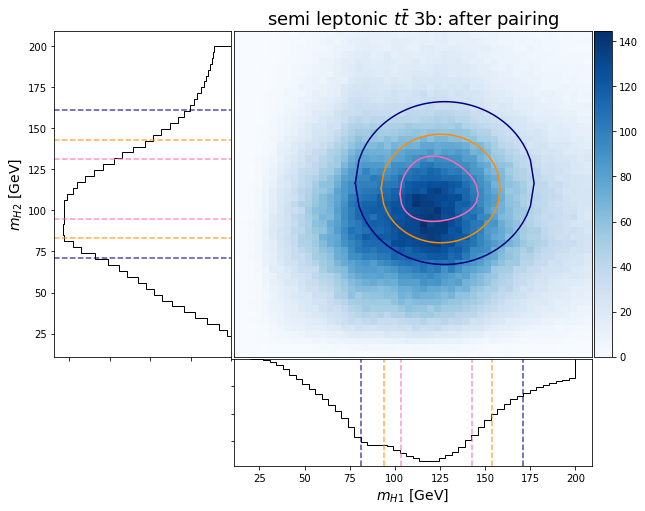

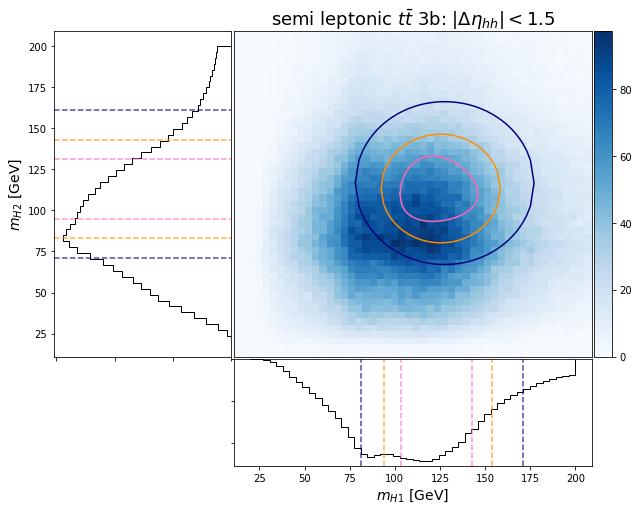

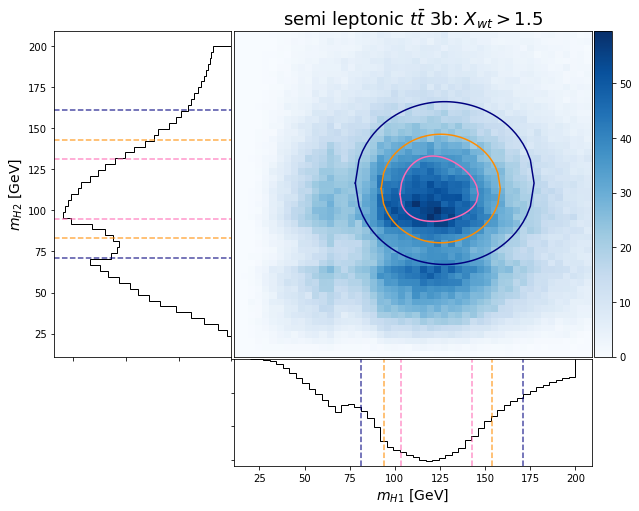

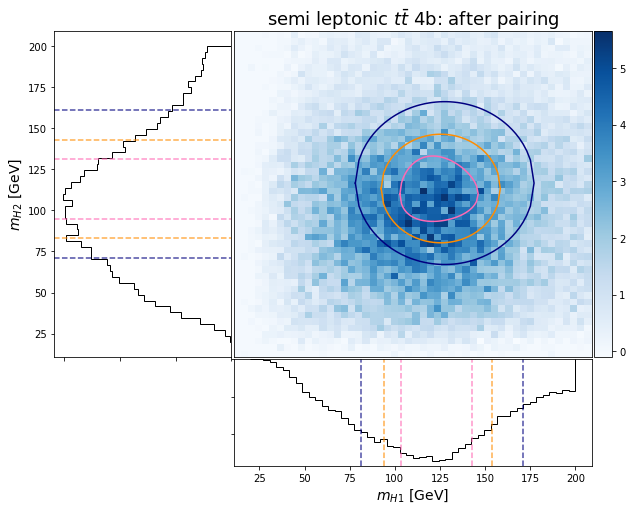

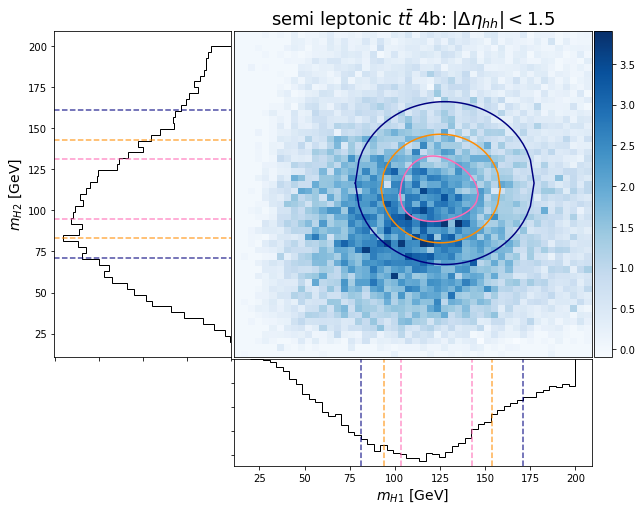

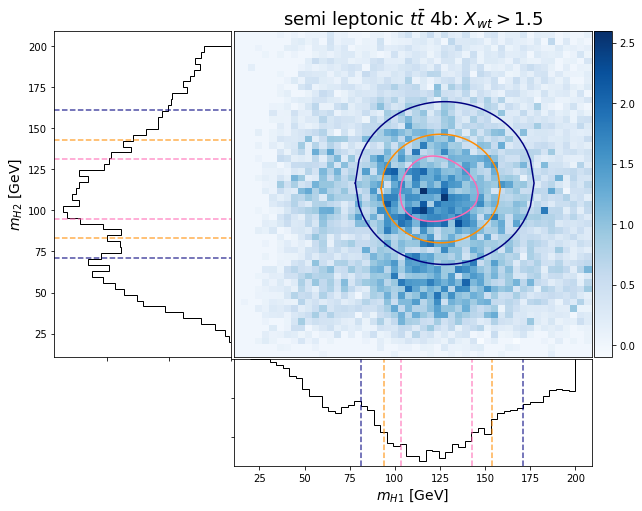

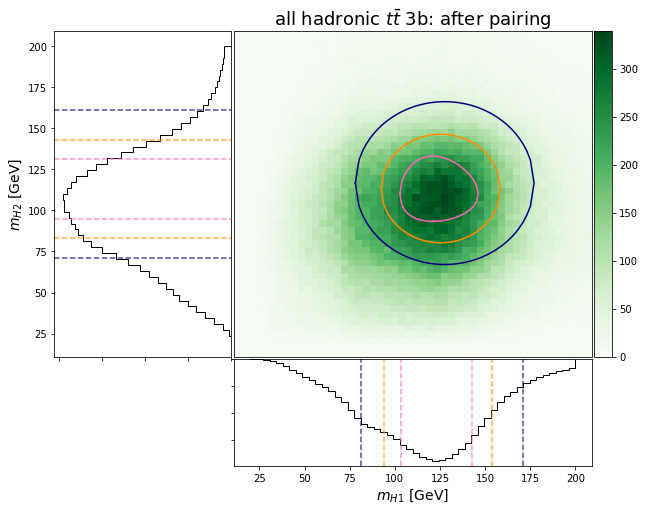

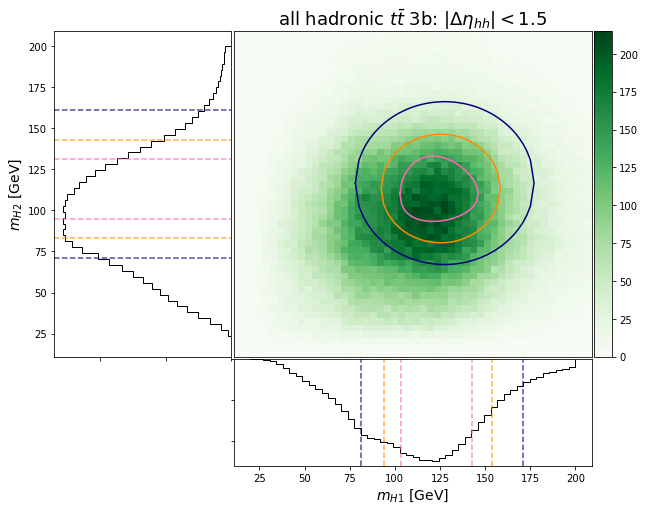

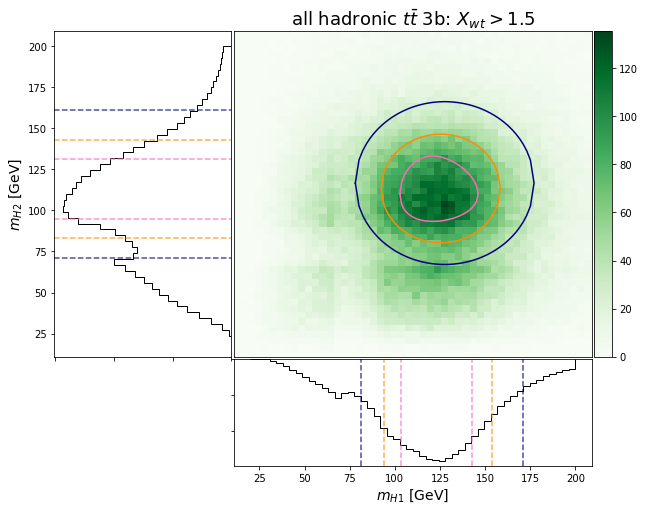

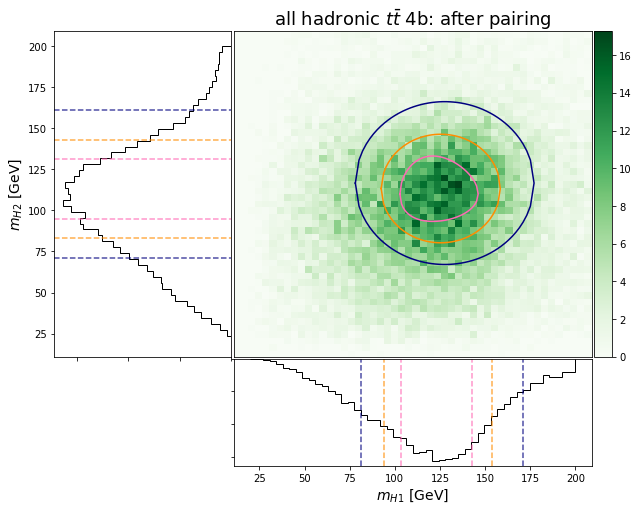

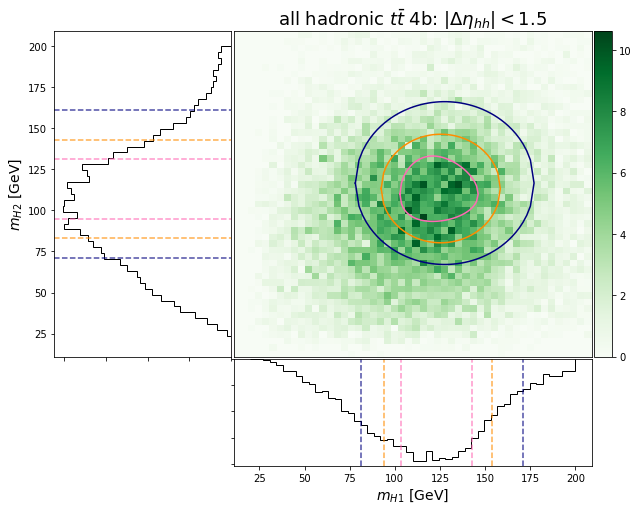

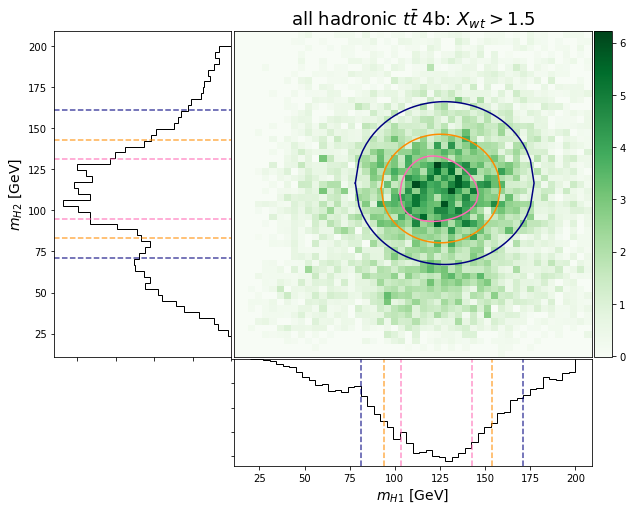

In [38]:
for ddf, decayMode, pre, cmap in zip([semilep_3b,allhad_3b],['semi leptonic','all hadronic'],
                                     ['semilep','allhad'],['Blues','Greens']):
    
    m_h1 = ddf['m_h1'].compute()
    m_h2 = ddf['m_h2'].compute()
    mc_sf = ddf['mc_sf'].compute().values

    dfi = pd.DataFrame(np.vstack([m_h1.values,m_h2.values]).T, columns=['m_h1','m_h2'])
    
    ddf['abs_deta_hh'] = (ddf['eta_h1'] - ddf['eta_h2']).abs()
    abs_deta_hh = ddf['abs_deta_hh'].compute().values
    X_wt = ddf['X_wt'].compute().values
    ntag = ddf['ntag'].compute().values
    
    for ntag, mi in zip([3,4], [ntag==3, ntag>=4]):
        
        # After pairing
        m = mi
        massplane(dfi[m],cmap=cmap,title=decayMode+r' $t\bar{t}$ '+f'{ntag}b: after pairing',
                  bins=[50,50],weights=mc_sf[m],save=True,
                  filename=f'figures/{pre}{dirTag}/SM_2b/massplane_{ntag}b_afterPairing.pdf')

        # deta_hh
        m = m & (abs_deta_hh < 1.5)
        massplane(dfi[m],cmap=cmap,title=decayMode+r' $t\bar{t}$ '+f'{ntag}b:'+' $|\Delta \eta_{hh}| < 1.5$',
                  bins=[50,50],weights=mc_sf[m],save=True,
                  filename=f'figures/{pre}{dirTag}/SM_2b/massplane_{ntag}b_deta_hh_cut.pdf')


        # X_wt
        m = m & (X_wt > 1.5)
        massplane(dfi[m],cmap=cmap,title=decayMode+r' $t\bar{t}$ '+f'{ntag}b:'+' $X_{wt} > 1.5$',
                  bins=[50,50],weights=mc_sf[m],save=True,
                  filename=f'figures/{pre}{dirTag}/SM_2b/massplane_{ntag}b_Xwt_cut.pdf')



Ok, but I think for the next set of studies, it's fair to just focus on the samples in the regions of interest (CR, VR, SR), and after the $\Delta \eta_{hh}$ cut (which will help all of the dfs fit into memory). 

In [39]:
ddf.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_hh', 'pt_hh', 'X_wt', 'm_hh_cor', 'pT_h1',
       'eta_h1', 'phi_h1', 'm_h1', 'dRjj_h1', 'dPhi_h1', 'pT_h2', 'eta_h2',
       'phi_h2', 'm_h2', 'dRjj_h2', 'dPhi_h2', 'pT_2', 'pT_4', 'eta_i',
       'dRjj_1', 'dRjj_2', 'cosThetaStar', 'cosTheta1', 'cosTheta2', 'Phi',
       'Phi1', 'ml_j0_Db', 'ml_j1_Db', 'ml_j2_Db', 'ml_j3_Db', 'ml_j4_Db',
       'HT', 'MDR', 'MDpT', 'max_prob', 'abs_deta_hh'],
      dtype='object')

In [40]:
cols = ['mc_sf','ntag','njets','kinematic_region','m_hh','X_wt','cosThetaStar','max_prob']

In [41]:
allhad_3b.loc[(allhad_3b.abs_deta_hh<1.5) & (allhad_3b.kinematic_region!=-2),cols].head()

mc_sf  ntag  njets  kinematic_region        m_hh      X_wt  \
entry                                                                  
1      0.247817     3      5                 0  355.701035  1.872717   
55     0.256866     3      4                -1  441.481480  1.028809   
59     0.230219     3      5                -1  501.520239  4.182584   
105    0.217325     3      5                 0  317.731885  1.312131   
169    0.248669     3      5                -1  320.187752  1.821960   

       cosThetaStar  max_prob  
entry                          
1         -0.130048  0.429573  
55        -0.621083  0.688536  
59         0.695539  0.473620  
105        0.249188  0.684263  
169       -0.600467  0.360520

In [42]:
sl_2b = semilep_2b.loc[(semilep_2b.abs_deta_hh<1.5) & (semilep_2b.kinematic_region!=-1),cols].compute()
sl_3b = semilep_3b.loc[(semilep_3b.abs_deta_hh<1.5) & (semilep_3b.kinematic_region!=-1),cols].compute()

ah_2b = allhad_2b.loc[ (allhad_2b.abs_deta_hh<1.5)  &  (allhad_2b.kinematic_region!=-1),cols].compute()
ah_3b = allhad_3b.loc[ (allhad_3b.abs_deta_hh<1.5)  &  (allhad_3b.kinematic_region!=-1),cols].compute()

### $X_{wt}$, $m_{hh}$, max_prob

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures create

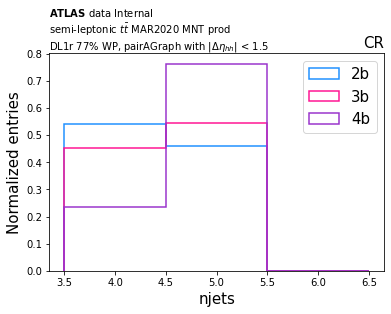

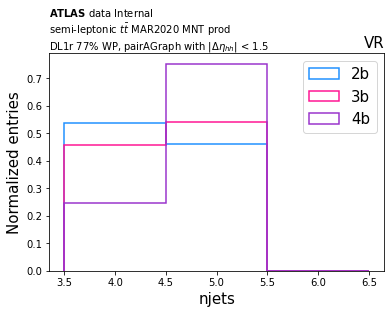

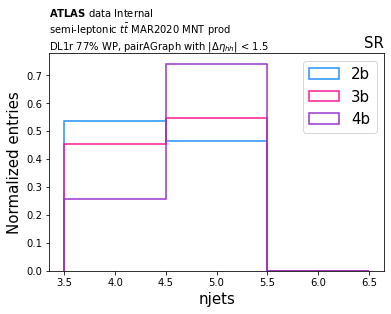

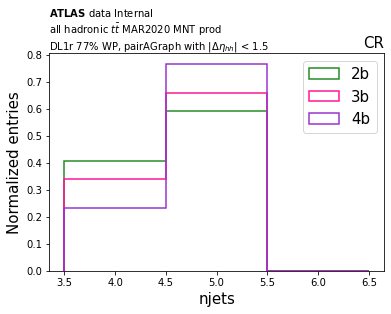

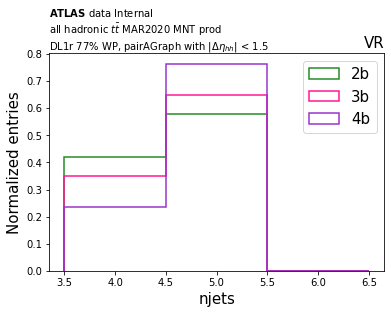

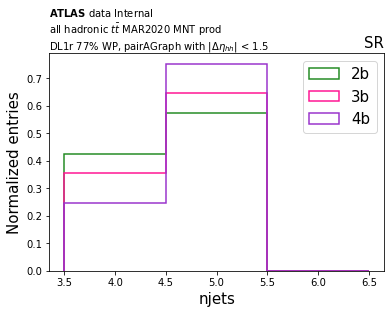

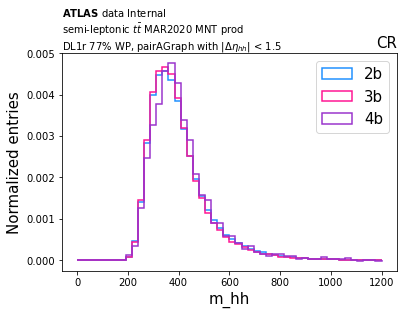

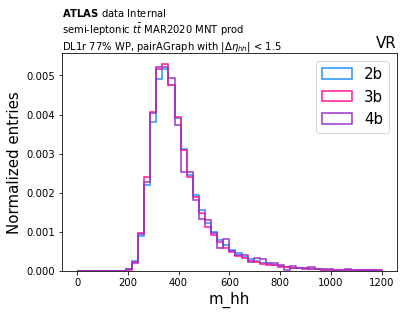

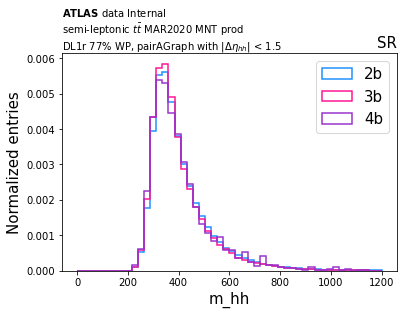

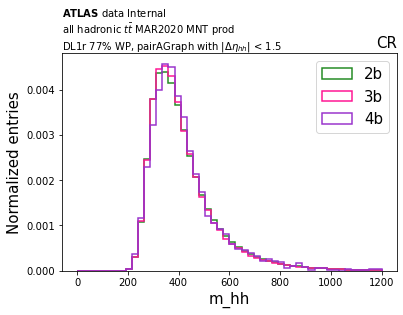

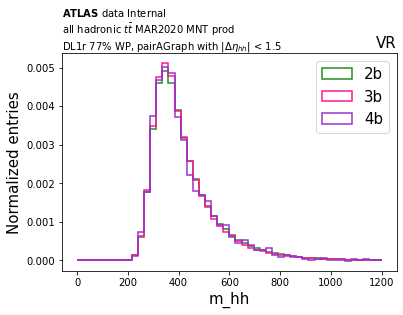

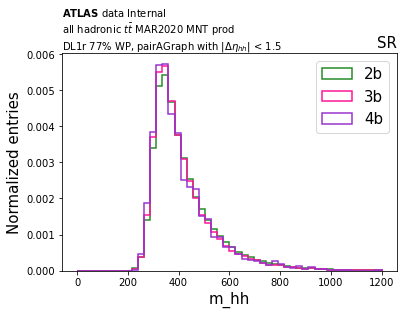

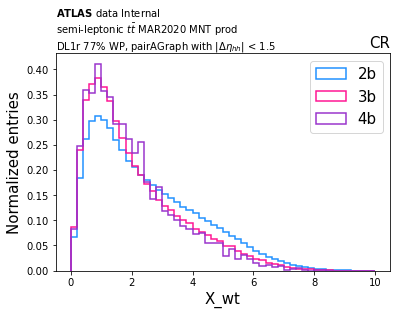

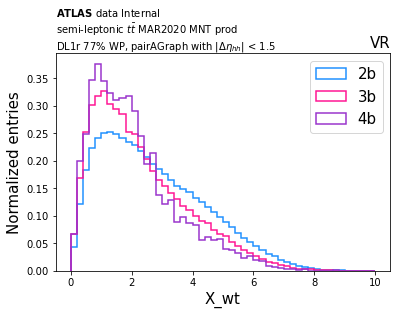

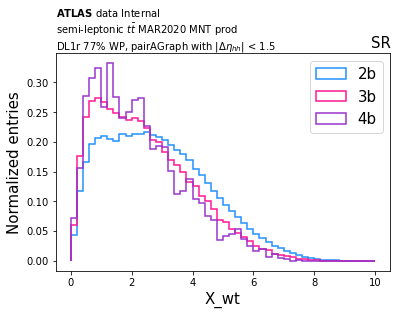

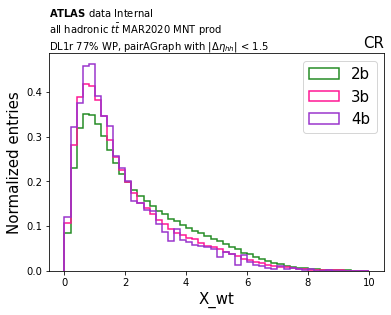

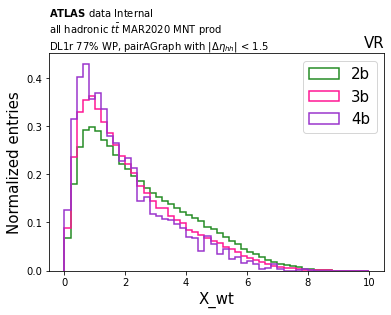

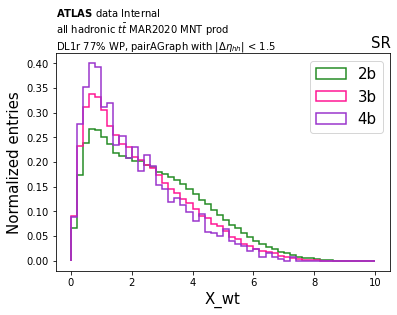

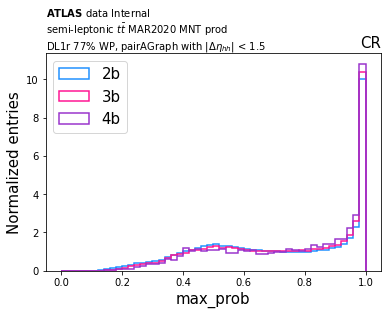

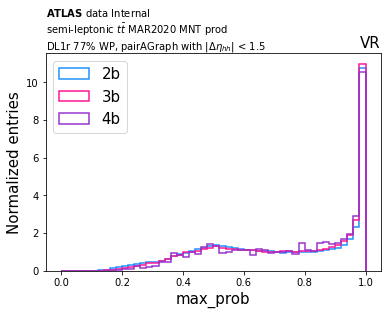

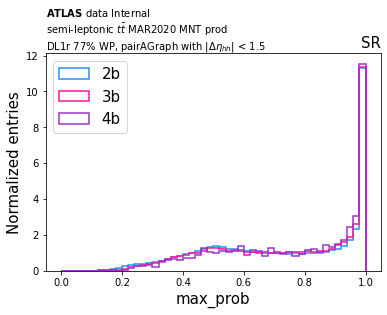

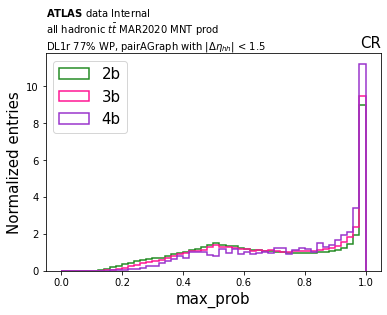

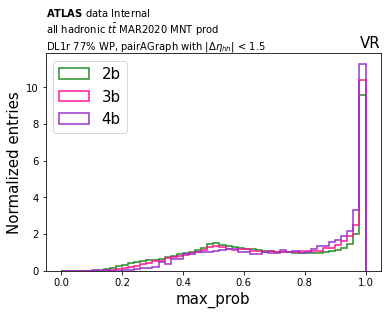

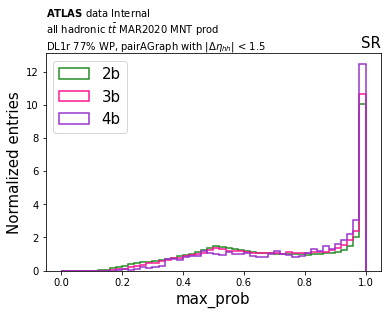

In [43]:
for col,nb,R in zip(['njets','m_hh','X_wt','max_prob'],[3,50,50,50],[(3.5,6.5),(0,1200),(0,10),(0,1)]):

    for df_2b,df_3b,decayMode,pre,c in zip([sl_2b,ah_2b],[sl_3b,ah_3b],['semi-leptonic','all hadronic'],
                                           ['semilep','allhad'],['dodgerblue','forestgreen']):

        text2 = "$\mathbf{ATLAS}$ data Internal\n"
        text2 += f"{decayMode}"
        text2 += r" $t\bar{t}$ MAR2020 MNT prod"
        text2 += "\nDL1r 77% WP, pairAGraph with $|\Delta \eta_{hh}|$ < 1.5"

        for r, region in zip([2,1,0],['CR','VR','SR']):

            plt.figure()

            mask = (df_2b.kinematic_region == r)
            plt.hist(df_2b.loc[mask,col],nb,R,color=c,histtype='step',
                     label='2b',lw=1.5,density=True,weights=df_2b.loc[mask,'mc_sf'])

            mask = (df_3b.kinematic_region == r) & (df_3b.ntag == 3)
            plt.hist(df_3b.loc[mask,col],nb,R,color='deeppink',histtype='step',
                     label='3b',lw=1.5,density=True,weights=df_3b.loc[mask,'mc_sf'])

            mask = (df_3b.kinematic_region == r) & (df_3b.ntag >= 4)
            plt.hist(df_3b.loc[mask,col],nb,R,color='darkorchid',histtype='step',
                     label='4b',lw=1.5,density=True,weights=df_3b.loc[mask,'mc_sf'])

            plt.legend(fontsize=15,loc='upper left' if col=='max_prob' else 'upper right')
            plt.xlabel(col,fontsize=15)
            plt.ylabel('Normalized entries',fontsize=15)
            plt.title(region,loc='right',fontsize=15)
            ax = plt.gca()
            plt.text(0,1,text2,ha='left',va='bottom',transform=ax.transAxes)

            # Save figure
            plt.savefig(f'figures/{pre}{dirTag}/SM_2b/{col}_{region}.pdf',bbox_inches='tight')

Now break this down into 4 jet and 5 jet events

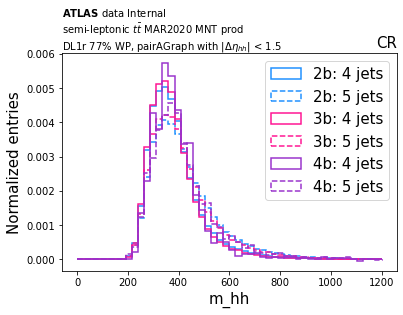

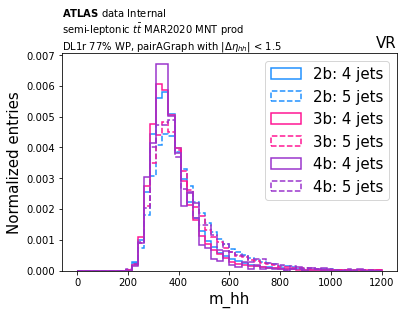

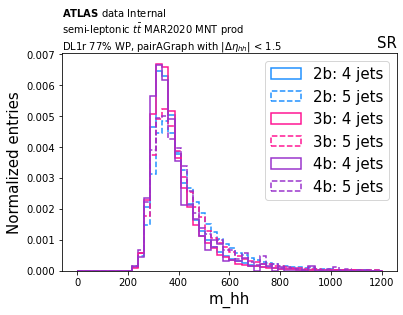

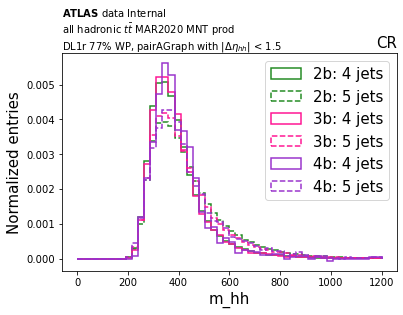

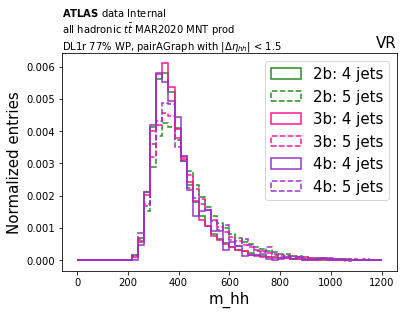

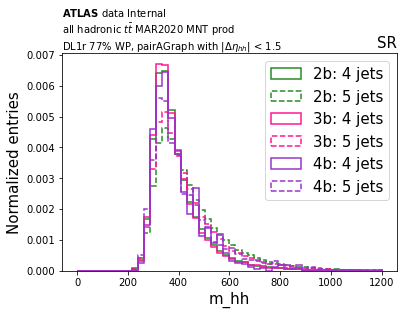

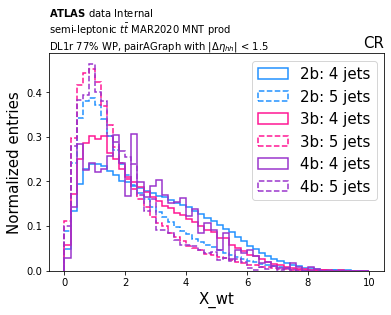

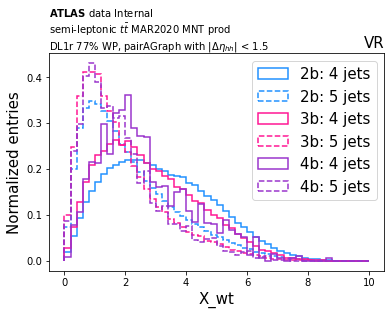

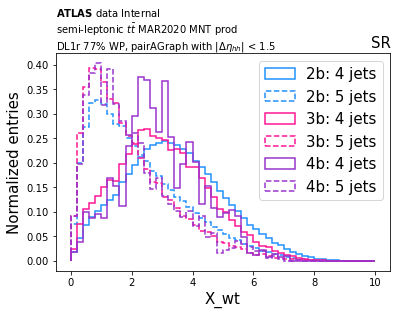

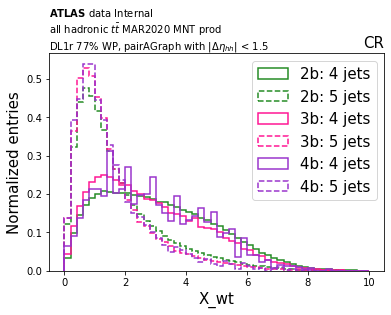

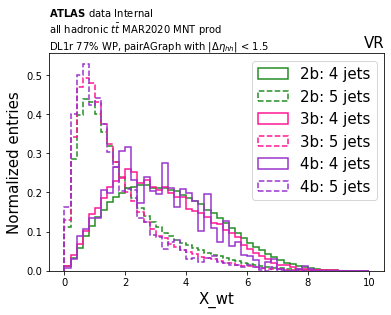

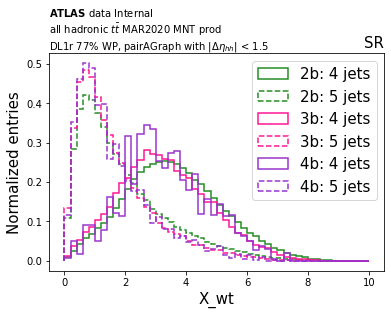

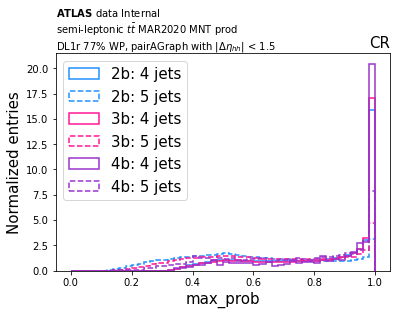

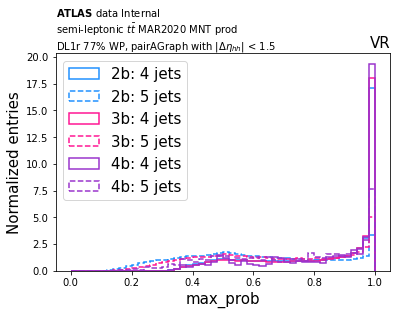

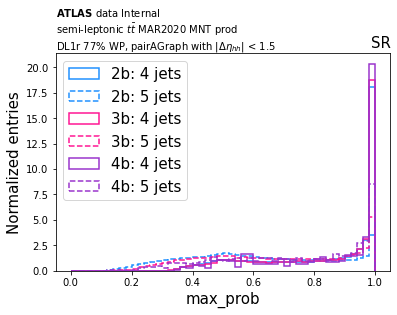

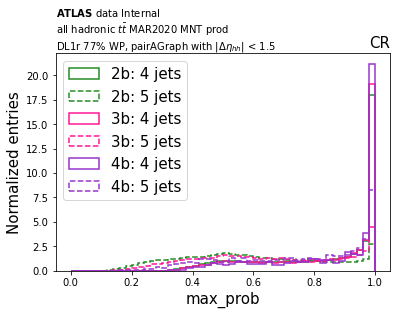

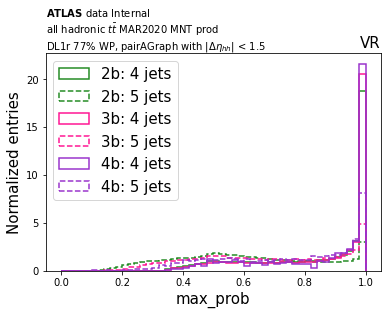

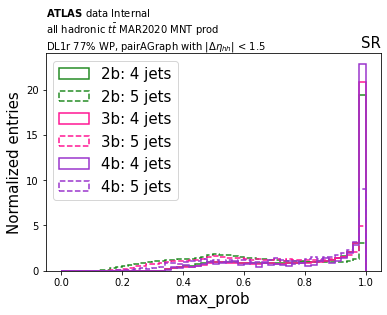

In [44]:
for col,nb,R in zip(['m_hh','X_wt','max_prob'],[50,50,50],[(0,1200),(0,10),(0,1)]):

    for df_2b,df_3b,decayMode,pre,c in zip([sl_2b,ah_2b],[sl_3b,ah_3b],['semi-leptonic','all hadronic'],
                                           ['semilep','allhad'],['dodgerblue','forestgreen']):

        text2 = "$\mathbf{ATLAS}$ data Internal\n"
        text2 += f"{decayMode}"
        text2 += r" $t\bar{t}$ MAR2020 MNT prod"
        text2 += "\nDL1r 77% WP, pairAGraph with $|\Delta \eta_{hh}|$ < 1.5"

        for r, region in zip([2,1,0],['CR','VR','SR']):

            plt.figure()

            mask = (df_2b.kinematic_region == r) & (df_2b.njets == 4) 
            plt.hist(df_2b.loc[mask,col],nb,R,color=c,histtype='step',
                     label='2b: 4 jets',lw=1.5,density=True,weights=df_2b.loc[mask,'mc_sf'])
            
            mask = (df_2b.kinematic_region == r) & (df_2b.njets == 5) 
            plt.hist(df_2b.loc[mask,col],nb,R,color=c,histtype='step',ls='--',
                     label='2b: 5 jets',lw=1.5,density=True,weights=df_2b.loc[mask,'mc_sf'])

            mask = (df_3b.kinematic_region == r) & (df_3b.ntag == 3) & (df_3b.njets == 4)
            plt.hist(df_3b.loc[mask,col],nb,R,color='deeppink',histtype='step',
                     label='3b: 4 jets',lw=1.5,density=True,weights=df_3b.loc[mask,'mc_sf'])

            mask = (df_3b.kinematic_region == r) & (df_3b.ntag == 3) & (df_3b.njets == 5)
            plt.hist(df_3b.loc[mask,col],nb,R,color='deeppink',histtype='step',ls='--',
                     label='3b: 5 jets',lw=1.5,density=True,weights=df_3b.loc[mask,'mc_sf'])
            
            mask = (df_3b.kinematic_region == r) & (df_3b.ntag >= 4) & (df_3b.njets == 4)
            plt.hist(df_3b.loc[mask,col],nb,R,color='darkorchid',histtype='step',
                     label='4b: 4 jets',lw=1.5,density=True,weights=df_3b.loc[mask,'mc_sf'])
            
            mask = (df_3b.kinematic_region == r) & (df_3b.ntag >= 4) & (df_3b.njets == 5)
            plt.hist(df_3b.loc[mask,col],nb,R,color='darkorchid',histtype='step',ls='--',
                     label='4b: 5 jets',lw=1.5,density=True,weights=df_3b.loc[mask,'mc_sf'])

            plt.legend(fontsize=15,loc='upper left' if col=='max_prob' else 'upper right')
            plt.xlabel(col,fontsize=15)
            plt.ylabel('Normalized entries',fontsize=15)
            plt.title(region,loc='right',fontsize=15)
            ax = plt.gca()
            plt.text(0,1,text2,ha='left',va='bottom',transform=ax.transAxes)

            # Save figure
            plt.savefig(f'figures/{pre}{dirTag}/SM_2b/{col}_{region}_njets.pdf',bbox_inches='tight')

Should probably still @ some point look at max_prob as a function of $m_{hh}$, but I don't have a reason to expect that it's doing something different from signal and data.

##  $|cos \Theta^*|$

**Goal:** When I was looking at the 2016 data, it seemed like the higher $|\cos \Theta^*|$ values were corresponding to the background peaking in th SR, and I was curious if this 


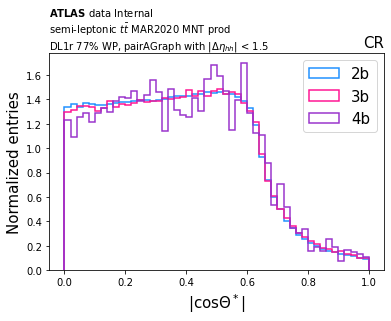

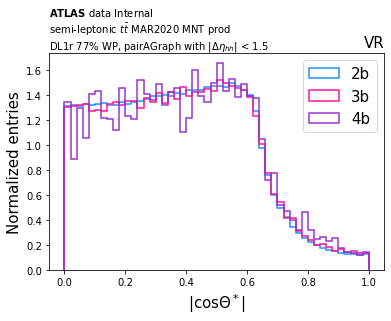

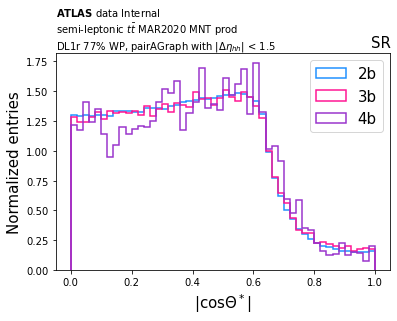

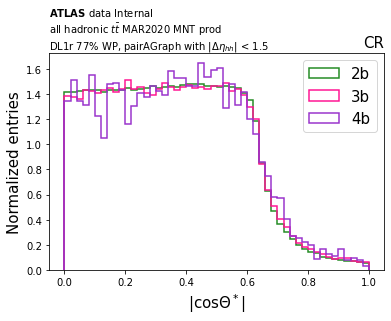

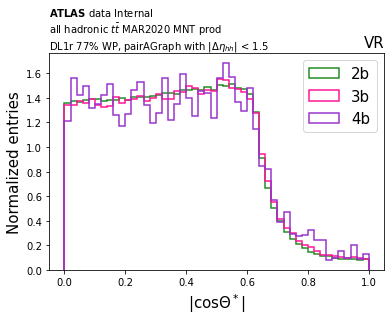

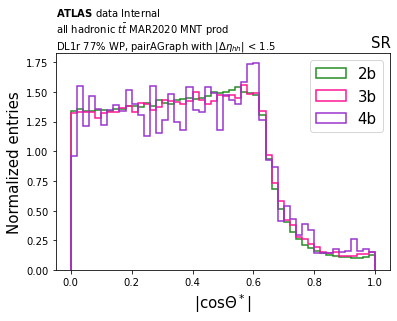

In [45]:
nb = 50
R= (0,1)

for df_2b, df_3b, decayMode, pre, c in zip([sl_2b,ah_2b],[sl_3b,ah_3b],['semi-leptonic','all hadronic'],
                                           ['semilep','allhad'],['dodgerblue','forestgreen']):

    text2 = "$\mathbf{ATLAS}$ data Internal\n"
    text2 += f"{decayMode}"
    text2 += r" $t\bar{t}$ MAR2020 MNT prod"
    text2 += "\nDL1r 77% WP, pairAGraph with $|\Delta \eta_{hh}|$ < 1.5"
    
    for r, region in zip([2,1,0],['CR','VR','SR']):

        plt.figure()

        mask = (df_2b.kinematic_region == r)
        plt.hist(np.abs(df_2b.loc[mask,'cosThetaStar']),nb,R,color=c,histtype='step',
                 label='2b',lw=1.5,density=True,weights=df_2b.loc[mask,'mc_sf'])

        mask = (df_3b.kinematic_region == r) & (df_3b.ntag == 3)
        plt.hist(np.abs(df_3b.loc[mask,'cosThetaStar']),nb,R,color='deeppink',histtype='step',
                 label='3b',lw=1.5,density=True,weights=df_3b.loc[mask,'mc_sf'])

        mask = (df_3b.kinematic_region == r) & (df_3b.ntag >= 4)
        plt.hist(np.abs(df_3b.loc[mask,'cosThetaStar']),nb,R,color='darkorchid',histtype='step',
                 label='4b',lw=1.5,density=True,weights=df_3b.loc[mask,'mc_sf'])

        plt.legend(fontsize=15)
        plt.xlabel('$|\cos \Theta^*|$',fontsize=15)
        plt.ylabel('Normalized entries',fontsize=15)
        plt.title(region,loc='right',fontsize=15)
        ax = plt.gca()
        plt.text(0,1,text2,ha='left',va='bottom',transform=ax.transAxes)

        # Save figure
        plt.savefig(f'figures/{pre}{dirTag}/SM_2b/absCosThetaStar_{region}.pdf',bbox_inches='tight')

Since I'm on a roll rn, I'll break this plot down by 4 and 5 jet events :)

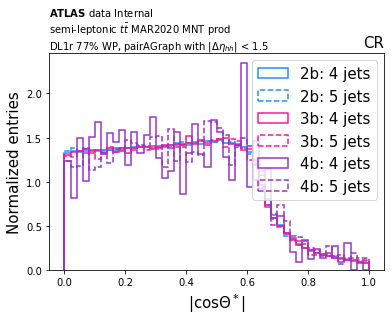

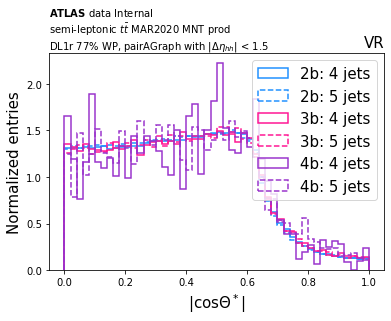

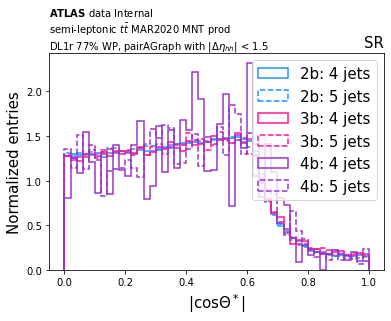

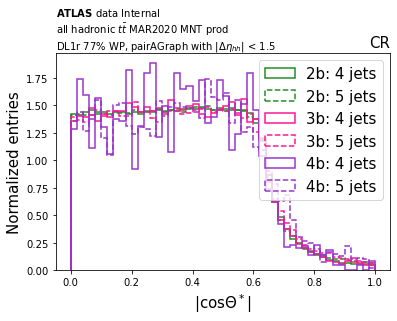

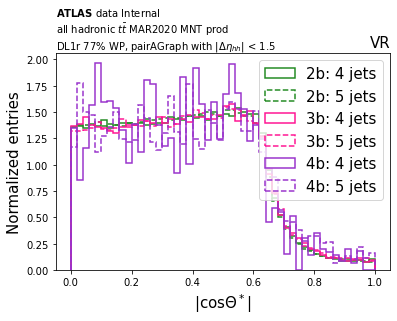

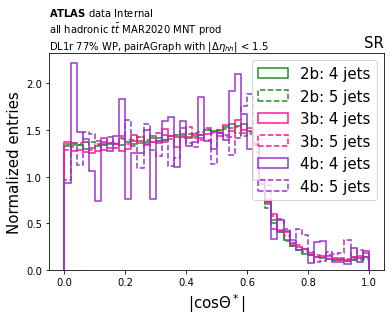

In [46]:
nb = 50
R= (0,1)

for df_2b, df_3b, decayMode, pre, c in zip([sl_2b,ah_2b],[sl_3b,ah_3b],['semi-leptonic','all hadronic'],
                                           ['semilep','allhad'],['dodgerblue','forestgreen']):

    text2 = "$\mathbf{ATLAS}$ data Internal\n"
    text2 += f"{decayMode}"
    text2 += r" $t\bar{t}$ MAR2020 MNT prod"
    text2 += "\nDL1r 77% WP, pairAGraph with $|\Delta \eta_{hh}|$ < 1.5"
    
    for r, region in zip([2,1,0],['CR','VR','SR']):

        plt.figure()

        mask = (df_2b.kinematic_region == r) & (df_2b.njets==4)
        plt.hist(np.abs(df_2b.loc[mask,'cosThetaStar']),nb,R,color=c,histtype='step',
                 label='2b: 4 jets',lw=1.5,density=True,weights=df_2b.loc[mask,'mc_sf'])
        
        mask = (df_2b.kinematic_region == r) & (df_2b.njets==5)
        plt.hist(np.abs(df_2b.loc[mask,'cosThetaStar']),nb,R,color=c,
                 histtype='step',ls='--',
                 label='2b: 5 jets',lw=1.5,density=True,weights=df_2b.loc[mask,'mc_sf'])

        mask = (df_3b.kinematic_region == r) & (df_3b.ntag == 3) & (df_3b.njets==4)
        plt.hist(np.abs(df_3b.loc[mask,'cosThetaStar']),nb,R,color='deeppink',histtype='step',
                 label='3b: 4 jets',lw=1.5,density=True,weights=df_3b.loc[mask,'mc_sf'])
        
        mask = (df_3b.kinematic_region == r) & (df_3b.ntag == 3) & (df_3b.njets==5)
        plt.hist(np.abs(df_3b.loc[mask,'cosThetaStar']),nb,R,color='deeppink',
                 histtype='step',ls='--',
                 label='3b: 5 jets',lw=1.5,density=True,weights=df_3b.loc[mask,'mc_sf'])

        mask = (df_3b.kinematic_region == r) & (df_3b.ntag >= 4) & (df_3b.njets==4)
        plt.hist(np.abs(df_3b.loc[mask,'cosThetaStar']),nb,R,color='darkorchid',histtype='step',
                 label='4b: 4 jets',lw=1.5,density=True,weights=df_3b.loc[mask,'mc_sf'])
        
        mask = (df_3b.kinematic_region == r) & (df_3b.ntag >= 4) & (df_3b.njets==5)
        plt.hist(np.abs(df_3b.loc[mask,'cosThetaStar']),nb,R,color='darkorchid',
                 histtype='step',ls='--',
                 label='4b: 5 jets',lw=1.5,density=True,weights=df_3b.loc[mask,'mc_sf'])

        plt.legend(fontsize=15)
        plt.xlabel('$|\cos \Theta^*|$',fontsize=15)
        plt.ylabel('Normalized entries',fontsize=15)
        plt.title(region,loc='right',fontsize=15)
        ax = plt.gca()
        plt.text(0,1,text2,ha='left',va='bottom',transform=ax.transAxes)

        # Save figure
        plt.savefig(f'figures/{pre}{dirTag}/SM_2b/absCosThetaStar_{region}_njets.pdf',bbox_inches='tight')

Ok - so the uptick @ 1 in the SR could possibly be due to the all hadronic $t\bar{t}$, although since it's so subtle, I'm now more convinced that this is being dominated by QCD.

In [ ]:
# for cmin,cmax in zip(np.arange(0,1,.1),np.arange(0.1,1.1,.1)):
#     mask = (df.abs_deta_hh < 1.5) & (df.ntag == 3) & (df.kinematic_region != 0)
#     mask = mask & (df.absCosThetaStar > cmin) & (df.absCosThetaStar < cmax)
#     plt.figure(figsize=(6,5))
#     plt.hist2d(df.loc[mask,'m_h1'],df.loc[mask,'m_h2'],
#                20,[[126-45,126+45],[116-45,116+45]],cmap='YlGnBu')
#     plt.plot(SR_x, SR_y1,'hotpink',linewidth=2.5)
#     plt.plot(SR_x, SR_y2,'hotpink',linewidth=2.5)
#     plt.plot(CR_x, CR_y1,'darkorange',linewidth=2.5)
#     plt.plot(CR_x, CR_y2,'darkorange',linewidth=2.5)
#     plt.plot(SB_x, SB_y1,'navy',linewidth=2.5)
#     plt.plot(SB_x, SB_y2,'navy',linewidth=2.5)
#     plt.xlabel('$m_{h1}$ [GeV]',fontsize=16)
#     plt.ylabel('$m_{h2}$ [GeV]',fontsize=16)
#     plt.colorbar()
#     if cmin == 0:
#         title = f'3b: $|\cos \Theta^*| < ${cmax:.1}'
#         t=f'_{cmax:.1}'
#     elif cmax ==1:
#         title = f'3b: $|\cos \Theta^*| > ${cmin:.1}'
#         t=f'_{cmin:.1}'
#     else:
#         title = f'3b: {cmin:.1}$ < |\cos \Theta^*| < ${cmax:.1}'
#         t=f'_{cmin:.1}_{cmax:.1}'
#     plt.title(title,loc='right',fontsize=16)
#     plt.savefig(f'figures/{subDir}_3b_detaCut/massplane_zoom_absCosThetaStar{t}.pdf')
#     plt.show()